# Step 4: Creating Decision Tree Regressor from scratch

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings

In [2]:
current_dir = os.getcwd()

In [3]:
for dirpath, dirname, filenames in os.walk(current_dir):
    for filename in filenames:
        print(filename)

creating_dataframe.ipynb
data_analysis.ipynb
data_preprocessing.ipynb
decision_tree_and_random_forest_modelling.ipynb
creating_dataframe-checkpoint.ipynb
data_analysis-checkpoint.ipynb
data_preprocessing-checkpoint.ipynb
decision_tree_and_random_forest_modelling-checkpoint.ipynb


In [36]:
df = pd.read_csv('../dataset/failed_hdds_with_rul.csv')

In [37]:
df.shape

(18588, 31)

In [38]:
df.head()

,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_3_raw,smart_4_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,...,smart_193_raw,smart_194_normalized,smart_194_raw,smart_197_normalized,smart_197_raw,smart_198_normalized,smart_198_raw,smart_199_normalized,smart_199_raw,date_diff_days
0,4000787030016,0,119.0,208663312.0,92.0,0.0,100.0,9.0,100.0,0.0,...,7273.0,23.0,23.0,100.0,0.0,100.0,0.0,200.0,0.0,26
1,12000138625024,0,79.0,155920208.0,98.0,0.0,100.0,2.0,100.0,24.0,...,633.0,40.0,40.0,100.0,88.0,100.0,88.0,200.0,0.0,26
2,8001563222016,0,77.0,54823024.0,98.0,0.0,100.0,2.0,100.0,0.0,...,14936.0,29.0,29.0,100.0,0.0,100.0,0.0,200.0,0.0,52
3,12000138625024,0,84.0,235330528.0,94.0,0.0,100.0,5.0,100.0,0.0,...,1501.0,25.0,25.0,100.0,0.0,100.0,0.0,200.0,0.0,83
4,8001563222016,0,67.0,240427784.0,95.0,0.0,100.0,4.0,100.0,3896.0,...,14353.0,38.0,38.0,100.0,0.0,100.0,0.0,200.0,0.0,27


### Checking the lowest and highest values for RUL

In [39]:
min_value = df['date_diff_days'].min()
max_value = df['date_diff_days'].max()
print(f'Target values will range from {min_value} to {max_value} days')

Target values will range from 0 to 88 days


In [41]:
RUL = df['date_diff_days'].values
RUL

array([26, 26, 52, ...,  0,  0,  0], dtype=int64)

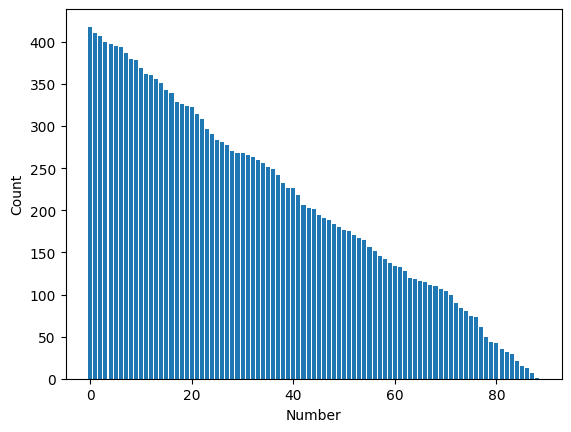

In [42]:
from collections import Counter

counter = Counter(RUL)
plt.bar(counter.keys(), counter.values())
plt.xlabel('Number')
plt.ylabel('Count')
plt.show()

### Creating train and test splits

In [43]:
X = df.drop(['date_diff_days'], axis=1).values

In [44]:
y = df['date_diff_days'].values

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
# Another method for train-test split?
split_index = int(0.8 * len(X))
X_train_2, X_test_2 = X[:split_index], X[split_index:]
y_train_2, y_test_2 = y[:split_index], y[split_index:]

### Decision Tree Regressor

In [132]:
class Node:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, value=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        
    def is_leaf(self):
        return self.value is not None


class MyDecisionTreeRegressor:
    def __init__(self, max_depth=None, min_samples_split=2, max_features=False):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.tree = None

    def fit(self, X, y):
        self.tree = self.grow_tree(X, y)

    def grow_tree(self, X, y, depth=0):
        num_samples, num_features = X.shape

        # 1. Stopping condition: either reached max depth or insufficient samples
        if depth == self.max_depth or num_samples < self.min_samples_split:
            leaf_value = np.mean(y)
            return Node(value=leaf_value)

        # 2. Find the best split
        feature_index, threshold = self.best_split(X, y)

        # 3. Stopping conditions if no valid split found
        if feature_index is None:
            return Node(value=np.mean(y))
        # If a feature index exists but there is no threshold
        if threshold is None:
            return Node(value=np.mean(y))

        # 4. Create boolean arrays for left and right splits
        indices_left = X[:, feature_index] <= threshold
        indices_right = X[:, feature_index] > threshold
        
        # 5. Use the boolean arrays to create subsets of data for left and right splits
        X_left, y_left = X[indices_left], y[indices_left]
        X_right, y_right = X[indices_right], y[indices_right]

        # 6. Recursively grow left and right subtrees
        left_subtree = self.grow_tree(X_left, y_left, depth + 1)
        right_subtree = self.grow_tree(X_right, y_right, depth + 1)

        # 7. Create and return the current node
        return Node(feature_index=feature_index, threshold=threshold, left=left_subtree, right=right_subtree)

    def best_split(self, X, y):
        num_samples, num_features = X.shape

        # 1. Check if there is only one sample or fewer, cannot split
        if num_samples <= 1:
            return None, None  

        # 2. Calculate the variance of the entire dataset
        var_parent = np.var(y)
        
        # 3. Initialise variables
        best_var_reduction = 0
        best_split = None, None
        column_indices = list(range(num_features))
        
        # Adding feature selection for Random Forest
        if self.max_features:
            column_indices = np.random.choice(a=column_indices, size=int(np.sqrt(num_features)), replace=False)
        
        # 4. Loop through each feature/column
        for feature_index in column_indices:
            # Get the unique values in the current feature
            thresholds = np.unique(X[:, feature_index])
            
            # 5. Loop through each unique value as a potential threshold
            for threshold in thresholds:
                # Create boolean arrays for the left and right splits
                indices_left = X[:, feature_index] <= threshold
                indices_right = X[:, feature_index] > threshold
                
                # Filter y to get the left and right subsets
                y_left = y[indices_left]  # keeps only the elements where indices_left is True
                y_right = y[indices_right]  # keeps only the elements where indices_right is True

                # 6. Skip the split if either side has too few samples
                if len(y_left) < self.min_samples_split or len(y_right) < self.min_samples_split:
                    continue

                # 7. Calculate the weighted variance of the child nodes
                weighted_var_child = ((len(y_left) / num_samples) * np.var(y_left) +
                                      (len(y_right) / num_samples) * np.var(y_right))

                # Calculate the variance reduction
                var_reduction = var_parent - weighted_var_child

                # 8. Update the best split if the variance reduction is higher
                if var_reduction > best_var_reduction:
                    best_var_reduction = var_reduction
                    best_split = (feature_index, threshold)
        
        return best_split

    def print_tree(self, node=None, indent='  '):
        if node is None:
            node = self.tree

        if node.is_leaf():
            # print(node.value)
            print(f'{node.value:.4f}')
        else:
            print(f'X{node.feature_index} <= {node.threshold}')

            print(f'{indent}Left: ', end='')
            self.print_tree(node.left, indent + '  ')

            print(f'{indent}Right: ', end='')
            self.print_tree(node.right, indent + '  ')


    def predict(self, X):
        return np.array([self.traverse_tree(x, self.tree) for x in X])

    def traverse_tree(self, x, node):
        if node.is_leaf():
            return node.value

        if x[node.feature_index] <= node.threshold:
            return self.traverse_tree(x, node.left)
        return self.traverse_tree(x, node.right)

### Testing the print tree function

In [63]:
DTR = MyDecisionTreeRegressor(max_depth=2, min_samples_split=2)
DTR.fit(X_train, y_train)
DTR.print_tree()

X1 <= 0.0
  Left: X9 <= 368.0
    Left: 31.4254
    Right: 18.6684
  Right: X21 <= 414.0
    Left: 0.0270
    Right: 0.0000


### Training the model with a reasonable depth

In [120]:
DTR = MyDecisionTreeRegressor(max_depth=40, min_samples_split=2)
DTR.fit(X_train, y_train)

In [121]:
y_pred_DTR = DTR.predict(X_test)

In [122]:
rmse_DTR = root_mean_squared_error(y_test, y_pred_DTR)
print(f'Decision Tree Regressor RMSE: {rmse_DTR}')

Decision Tree Regressor RMSE: 6.065767425231205


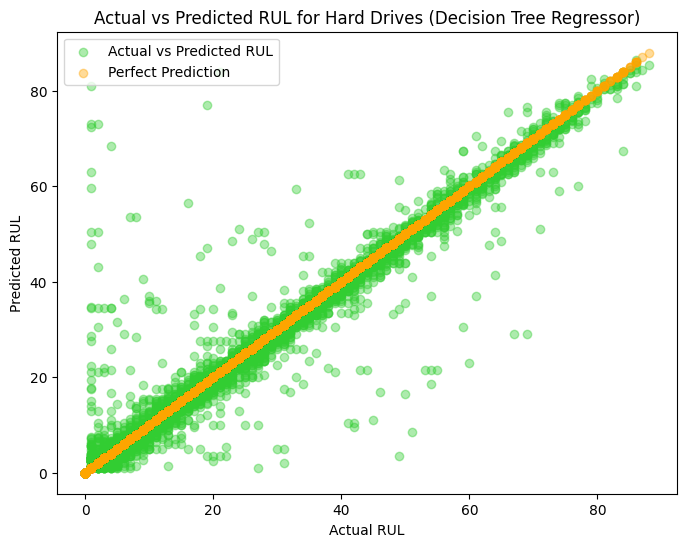

In [123]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_DTR, alpha=0.4, label='Actual vs Predicted RUL', color='limegreen')
plt.scatter(y_test, y_test, alpha=0.4, label='Perfect Prediction', color='orange')
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title('Actual vs Predicted RUL for Hard Drives (Decision Tree Regressor)')
plt.legend(loc='upper left')
plt.show()

### Implementing my own Random Forest Regressor from scratch

In [133]:
class RandomForestRegressor:
    def __init__(self, n_trees=100, max_depth=None, min_samples_split=2, max_features=True):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.trees = []  # List to store individual decision trees
        
    def fit(self, X, y):
        for _ in range(self.n_trees):
            # Perform bootstrap sampling (pick random values from the X_train samples)
            bootstrap_indices = np.random.choice(len(X), len(X), replace=True)
            # Create a new dataset using the bootstrap indices
            X_bootstrap, y_bootstrap = X[bootstrap_indices], y[bootstrap_indices]
            
            tree = MyDecisionTreeRegressor(max_depth=self.max_depth, min_samples_split=self.min_samples_split, max_features=self.max_features)
            tree.fit(X_bootstrap, y_bootstrap)
            self.trees.append(tree)
    
    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.trees])
        predictions = np.mean(predictions, axis=0)  # Calculating the mean of each column
        return predictions

In [146]:
RFR = RandomForestRegressor(n_trees=100, max_depth=100, min_samples_split=2, max_features=True)
RFR.fit(X_train, y_train)

In [147]:
y_pred_RFR = RFR.predict(X_test)

### with 100 trees and max_depth set to 100, rmse value came to 3.99
### 20 trees and 40 depth and max features set to false, rmse value came to 4.22
### 20 trees and 40 depth and max features set to true, rmse value came to 7.19
### 100 trees and 100 depth and max features set to false, rmse value came to 4.03
### 100 trees and 100 depth and max features set to true, rmse value came to 6.79

In [148]:
rmse_RFR = root_mean_squared_error(y_test, y_pred_RFR)
print(f'Decision Tree Regressor RMSE: {rmse_RFR}')

Decision Tree Regressor RMSE: 6.797243794173751


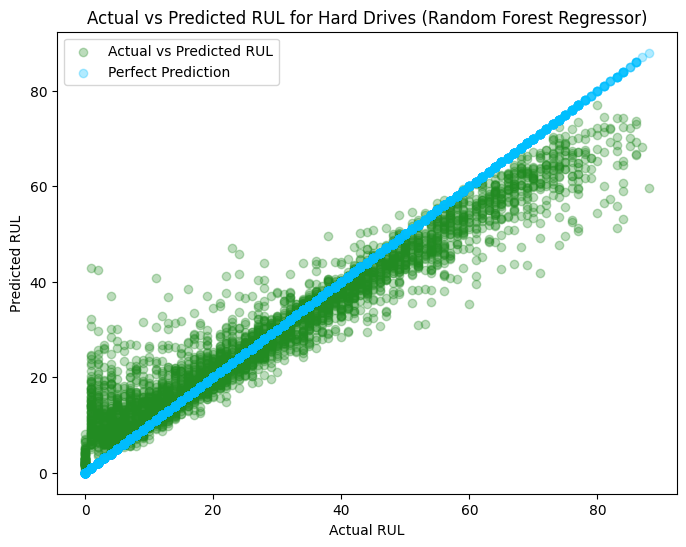

In [149]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_RFR, alpha=0.3, label='Actual vs Predicted RUL', color='forestgreen')
plt.scatter(y_test, y_test, alpha=0.3, label='Perfect Prediction', color='deepskyblue')
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title('Actual vs Predicted RUL for Hard Drives (Random Forest Regressor)')
plt.legend()
plt.show()